# Test

This notebook tests the functions and classes in myimagelib.

In [7]:
import os
cwd = os.getcwd()
import sys
sys.path.insert(0, os.path.abspath(os.path.join(cwd, "..", "..", "..", "src")))
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from skimage.io import imread
google_download_handle = "https://drive.google.com/uc?export=download&id={}"
import numpy as np
import cv2
from myimagelib import readdata, show_progress, to8bit, bestcolor, rawImage, imfindcircles, xy_bin, PIV, compact_PIV, apply_mask
import pandas as pd

## `myImageLib`

### `readdata`

In [8]:
l = readdata(".", "ipynb")
l

,Name,Dir
0,compact_PIV,.\compact_PIV.ipynb
1,find_circles,.\find_circles.ipynb
2,test,.\test.ipynb


### `show_progress`

In [9]:
show_progress(0.5, label="test", bar_length=80)

### `to8bit`

1. Download the test image.

In [10]:
# Download condensation image from the cloud
url = google_download_handle.format("1OTTXhvSrfgPmFcqjTQEaam9e5vgSEP79")  # replace with your image URL
response = requests.get(url, stream=True)
img = imread(BytesIO(response.content))

2. Convert to 8-bit and enhance the contrast.

(-0.5, 399.5, 499.5, -0.5)

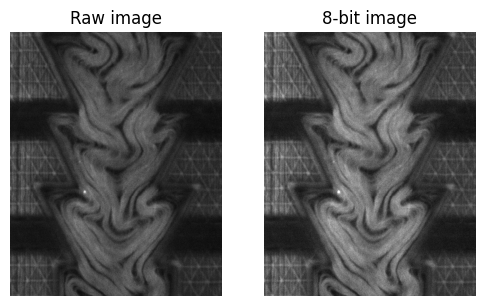

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Raw image")
ax[0].axis("off")
# Convert to 8-bit and enhance contrast
img8 = to8bit(img)
ax[1].imshow(img8, cmap="gray")
ax[1].set_title("8-bit image")
ax[1].axis("off")

### `imfindcircles`

1. Download the test image.

In [12]:
# Download condensation image from the cloud
url = google_download_handle.format("1LFRt5ozQjJ_WVrWBoPQOFVNl5ZWb8ytP")  # replace with your image URL
response = requests.get(url, stream=True)
img = imread(BytesIO(response.content))

(-0.5, 3935.5, 2623.5, -0.5)

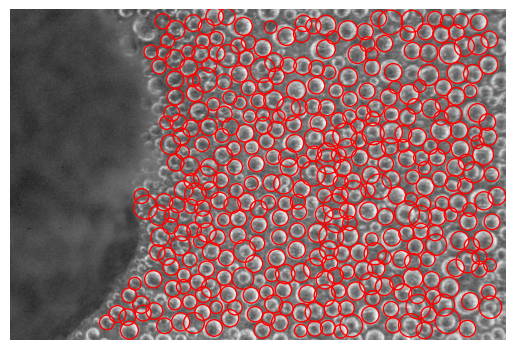

In [13]:
# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")
# find circles
circles = imfindcircles(gray, [50, 100], sensitivity=0.7, smooth_window=21)
for _, row in circles.iterrows():
    circ = plt.Circle((row["x"], row["y"]), row["r"], color='r', fill=False)
    plt.gca().add_patch(circ)
plt.axis("off")

### `xy_bin`

1. Generate dense data

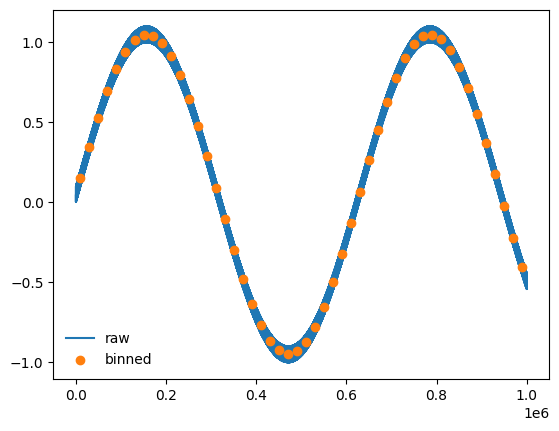

In [14]:
# craete a dense data
s = int(1e6)
x = np.arange(s)
y = np.sin(0.00001*x) + np.random.rand(s)*.1
# plot
plt.plot(x, y, label="raw")
xb, yb = xy_bin(x, y, n=50, mode="lin")
plt.scatter(xb, yb, color=bestcolor(1), label="binned", zorder=10)
plt.legend(frameon=False)

### `bestcolor`

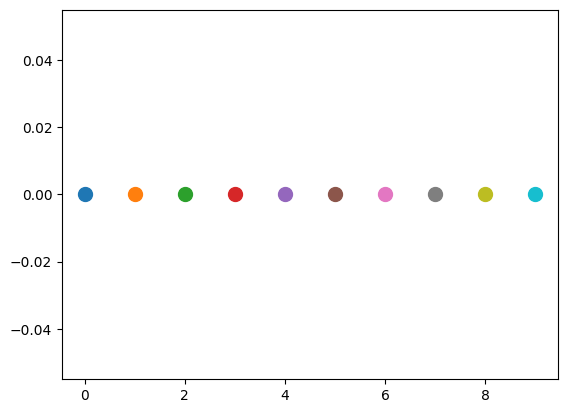

In [15]:
for i in range(10):
    plt.scatter(i, 0, s=100, color=bestcolor(i))

## `pivLib`

### ``PIV``

In [16]:
# Download condensation image from the cloud
url = google_download_handle.format("1lc5JlOipgvTGRtvSEavF82xe26iLyHFX")  # replace with your image URL
response = requests.get(url, stream=True)
I0 = imread(BytesIO(response.content))
url = google_download_handle.format("1QXTD6glGy_MAF2sSp9tiv6KeEEeuVz1q")  # replace with your image URL
response = requests.get(url, stream=True)
I1 = imread(BytesIO(response.content))

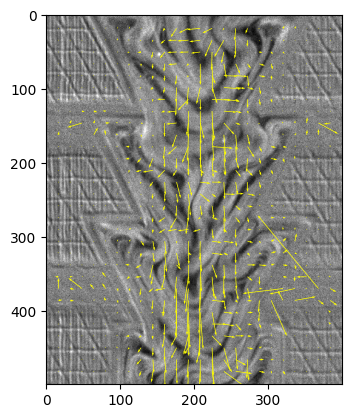

In [17]:
x, y, u, v = PIV(I0, I1, 32)
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u, -v, color="yellow")

### `to_dataframe`

In [18]:
from myimagelib.pivLib import to_dataframe
pivData = to_dataframe(x, y, u, v)
pivData.head()

,x,y,u,v
0,16.0,18.0,0.004263,-0.047905
1,32.0,18.0,0.017182,-0.063848
2,48.0,18.0,0.023226,-0.040136
3,64.0,18.0,0.040622,-0.049772
4,80.0,18.0,0.117607,-0.147990


### ``apply_mask``

In [19]:
url = google_download_handle.format("1r4Ry9eR-eKQoeTjxmJS9ZZ1aSaiHr-df")  # replace with your image URL
response = requests.get(url, stream=True)
mask = imread(BytesIO(response.content))

In [20]:
pivData = to_dataframe(x, y, u, v)
masked_pivData = apply_mask(pivData, mask)
masked_pivData.head()

,x,y,u,v,mask
0,16.0,18.0,0.004263,-0.047905,False
1,32.0,18.0,0.017182,-0.063848,False
2,48.0,18.0,0.023226,-0.040136,False
3,64.0,18.0,0.040622,-0.049772,False
4,80.0,18.0,0.117607,-0.147990,True


### `to_matrix`

In [21]:
from myimagelib.pivLib import to_matrix
x, y, u, v = to_matrix(masked_pivData)

## `corrLib`

In [22]:
from myimagelib.corrLib import corrS, corrI, divide_windows, distance_corr, \
    density_fluctuation, local_df, compute_energy_density, compute_wavenumber_field, \
        energy_spectrum, autocorr1d, vacf_piv

### `corrS`

In [24]:
x, y, u, v = to_matrix(pivData)
X, Y, CA, CV = corrS(x, y, u, v)

(<matplotlib.image.AxesImage at 0x28d8058c580>, (-0.5, 11.5, 14.5, -0.5))

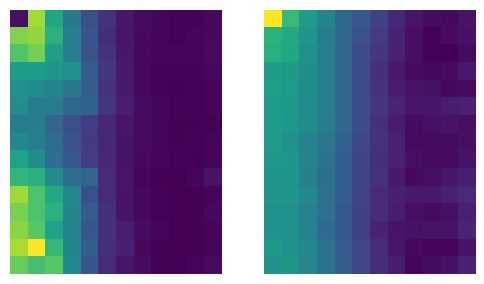

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(CA), ax[0].axis("off")
ax[1].imshow(CV), ax[1].axis("off")

### `divide_windows`

In [45]:
X, Y, I = divide_windows(I0, windowsize=[32, 32])

(-0.5, 36.5, 46.5, -0.5)

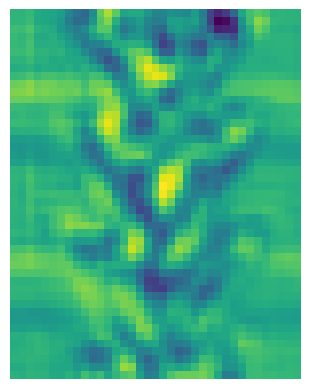

In [47]:
plt.imshow(I)
plt.axis("off")

### `distance_corr`

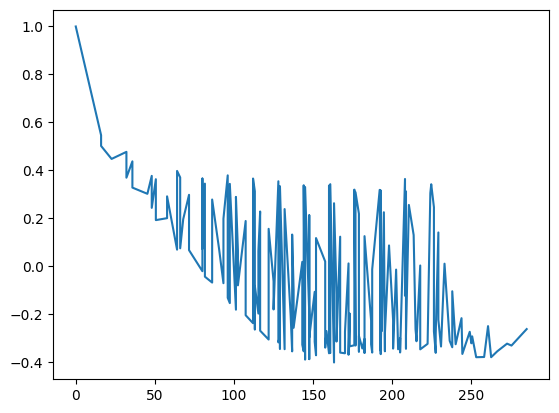

In [50]:
X, Y, CA, CV = corrS(x, y, u, v)
dc = distance_corr(X, Y, CV)
plt.plot(dc.R, dc.C)

### `energy_spectrum`

In [51]:
es = energy_spectrum(pivData, d=25*0.33)

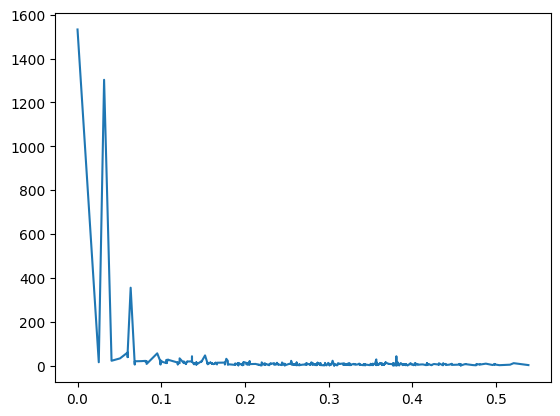

In [53]:
plt.plot(es.k, es.E)

### `autocorr1d`

In [55]:
t = np.linspace(0, 10)
x = np.sin(t)
corr, t = autocorr1d(x, t)

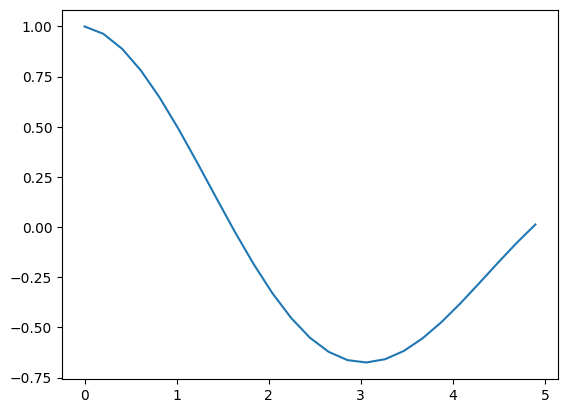

In [56]:
plt.plot(t, corr)